# Setup

In [1]:
''' magic 4u'''
%load_ext autoreload
%autoreload 2

In [2]:
'''Get Stuff You Need'''
import numpy as np
import math as math
from tqdm import tnrange
from tqdm.notebook import tqdm as tdqm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import scipy.io
import scipy.ndimage.filters as filt
import pandas as pd
import seaborn as sns

from pipeline import get_data as get
from pipeline import process_spikes as ps

from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
from itertools import combinations

In [3]:
''' Define plotting defaults '''

from matplotlib import rc 
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
''' Load in Animal Metadata '''

animalmeta = pd.read_csv('C:/Users/Python/Desktop/Dryad/MouseMetadata.csv') # adjust path name

# define some useful lists of animals based on metadata
all_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3),'Animal_ID'])
all_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2),'Animal_ID'])
all_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1),'Animal_ID'])

cohorta_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'A'),'Animal_ID'])
cohortb_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'B'),'Animal_ID'])
cohortc_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'C'),'Animal_ID'])
cohortd_mice = np.array(animalmeta.loc[(animalmeta.Cohort == 'D'),'Animal_ID'])

RF_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_aged_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 3) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_MA_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 2) & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_young_mice = np.array(animalmeta.loc[(animalmeta.Age_Group == 1) & (animalmeta.Task == 'SM'),'Animal_ID'])

all_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F'),'Animal_ID'])
all_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M'), 'Animal_ID'])
RF_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'RF'),'Animal_ID'])
RF_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'RF'),'Animal_ID'])
SM_female_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'F') & (animalmeta.Task == 'SM'),'Animal_ID'])
SM_male_mice = np.array(animalmeta.loc[(animalmeta.Sex == 'M') & (animalmeta.Task == 'SM'),'Animal_ID'])

animalmeta.head()

,Animal_ID,Task,Cohort,Probe_Control,Sex,Sac_Date,Frozen_Hemisphere,DOB,Age_WholeMonth,Age_ExtraDays,Age_Month,Aged_Days,Age_Group,Behavior_Sessions,Neural_Sessions
0,A3,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
1,A4,RF,A,0,F,1/27/2021,R,4/23/2019,21,4,21.217,645,3,6,6
2,A5,RF,A,0,F,4/6/2021,L,4/23/2019,23,14,23.487,714,3,6,6
3,A6,RF,A,0,F,4/6/2021,R,4/23/2019,23,14,23.487,714,3,6,6
4,A7,RF,A,0,F,4/19/2021,L,5/29/2019,22,21,22.730,691,3,6,6


In [5]:
'''Load Session Metadata'''
sessionmeta = pd.read_csv('C:/Users/Python/Desktop/LocalData/sessionmeta.csv') # adjust this path
print(sessionmeta.head())

                                    File Animal_ID  Session  Sync  \
0  A3_210122_randomforagecuerich_record1        A3      1.0   1.0   
1  A3_211023_randomforagecuerich_record2        A3      2.0   1.0   
2  A3_211024_randomforagecuerich_record3        A3      3.0   1.0   
3  A3_210125_randomforagecuerich_record4        A3      4.0   1.0   
4  A3_210126_randomforagecuerich_record5        A3      5.0   1.0   

   Final Depth (D) Final Depth (V)  Angle   Difficulty SyncBlock  \
0           3510.0            3450   10.61         0.0         2   
1           3637.0            3575   10.59         0.0         2   
2           4120.0            4050   10.58         0.0         2   
3           3917.0            3850   10.61         0.0         2   
4           3765.0            3700   10.66         0.0         2   

           Notes  
0  Pulse amp low  
1  Pulse amp low  
2  Pulse amp low  
3  Pulse amp low  
4  Pulse amp low  


In [6]:
''' Complete List of Mice & Sessions '''
all_mice = np.array(animalmeta.Animal_ID)

all_sessions = ([['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'], 
             ['0122_record1','0123_record2','0124_record3','0125_record4','0126_record5','0127_record6'],
             ['0401_record1','0401_record2b','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0401_record1','0402_record2','0403_record3','0404_record4','0405_record5','0406_record6'],
             ['0414_record1','0415_record2','0416_record3','0417_record4','0418_record5','0419_record6'],
             ['1024_record1','1025_record2','1026_record3','1027_record4','1028_record5_2'], #Y2_6 excluded
             ['1016_record1','1019_record3','1020_record4','1021_record5','1022_record6'], #Y3_2 not collected
             ['1114_record1','1115_record2','1116_record3','1117_record4','1118_record5','1119_record6'], # end cohort A
             ['051822_record1','051922_record2', '052022_record3','052122_record4','052222_record5','052322_record6'], 
             ['050522_record1','050622_record2','050722_record3','050822_record4','050922_record5','051022_record6'],
             ['050522_record1','050622_record2','050722_record3','050822_record4','051022_record6'], #Y11_5 not collected
             ['062222_record3','062322_record4','062522_record5'], #Y16_1 & 2 not collected, neural _6 excluded
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'],
             ['062022_record1','062122_record2','062222_record3','062322_record4','062522_record5','062622_record6'],
             ['062822_record1','062922_record2','063022_record3','070122_record4','070222_record5','070322_record6'], 
             ['051922_record2','052022_record3'], # Y9 051822_record excluded for syncing issue, end cohort B
             ['083022_record1','083122_record2','090122_record3'], 
             ['083022_record1','083122_record2','090122_record3','090222_record4','090322_record5','090422_record6'],
             ['083022_record1','083122_record2','090122_record3','090222_record4'], #behavior of A16_4, both of 5 excluded, 6 not collected 
             ['082322_record1','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['082322_record1real','082422_record2','082522_record3','082622_record4','082722_record5','082822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['102322_record1','102422_record2','102522_record3','102622_record4','102722_record5','102822_record6'],
             ['103122_record2','110122_record3','110222_record4','110322_record5rep','110422_record6','110522_record7'], #behavior of MA4M6, 7 excluded
             ['110622_record1','110722_record2','110822_record3','110922_record4','111022_record5','111122_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4','110322_record5','110422_record6'],
             ['103022_record1','103122_record2','110122_record3','110222_record4'], #behavior of MA7_4, both 5 excluded, 6 not collected
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'],
             ['111322_record1','111422_record2','111522_record3','111622_record4','111722_record5','111822_record6'], 
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['092522_record1','092622_record2','092722_record3','092822_record4','092922_record5','093022_record6'],
             ['091822_record1','091922_record2','092022_record3','092122_record4','092222_record5','092322_record6'], #end cohortc
             ['012723_record2','012823_record3','012923_record4','013023_record5','013123_record6','020123_record7'],
             ['012623_record1','012723_record2','012823_record3','012923_record4','013023_record5','013123_record6'],
             ['012923_record2','013023_record3','013123_record4','020123_record5','020223_record6','020323_record7'],
             ['020923_record1','021023_record2','021123_record3','021223_record4','021323_record5','021423_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5','022123_record6'],
             ['021623_record1','021723_record2','021823_record3','021923_record4','022023_record5rep','022123_record6'],
             ['022623_record1','022723_record2','022823_record3','030123_record4','030223_record5','030323_record6'] #end cohort d 
            ]) #list of sessions

In [7]:
'''Define which mice & sessions to load'''
mice = all_mice
sessions = all_sessions
    
# Make a dict to hold data
data = {}

for session, m in zip(sessions, mice):
    data[m] = {}
    
    for s in session:
        data[m][s] = {}

# Edit these paths

In [9]:
#Inputs
load_folder = 'C:/Users/Python/Desktop/LocalData/filtered/' # adjust path to match output of Import & Filter
metrics_folder = 'C:/Users/Python/Desktop/Dryad/waveform_metrics/' # adjust to match location of this Dryad repo folder
shuffload_folder1 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedscores/' # adjust to match location of this Dryad repo folder
shuffload_folder2 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/speedstabscores/' # adjust to match location of this Dryad repo folder
shuffload_folder3 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsity/' # adjust to match location of this Dryad repo folder
shuffload_folder4 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherence/' # adjust to match location of this Dryad repo folder
shuffload_folder5 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/sparsitya/' # adjust to match location of this Dryad repo folder
shuffload_folder6 = 'C:/Users/Python/Desktop/Dryad/shuffle_scores/coherencea/' # adjust to match location of this Dryad repo folder
figs2_folder = 'C:/Users/Python/Desktop/LocalData/FigureS2/' # adjust to match Figure S2 output folder
fig5_folder = 'C:/Users/Python/Desktop/LocalData/Figure5/' # adjust to match Figure 5 output folder
fig6_folder = 'C:/Users/Python/Desktop/LocalData/Figure6/' # adjust to match Figure 6 output folder

#Output (create folder to hold the output of this notebook; then match the name of this repository below)
save_folder = 'C:/Users/Python/Desktop/LocalData/FigureS6/' # should already exist & match Shuffle Procedure output plotsave_folder

In [10]:
''' Gather waveform properties of putative excitatory vs. inhibitory interneurons '''

PTRe = []
PTRi = []
duratione = []
durationi = []

for m, session in zip(mice,sessions):
    
    seshcount = 1 
    
    for s in session:
        d = data[m][s]
        
        #load in session data & waveform metrics data
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
 
        file_name = m + '_' + str(seshcount) + '_metrics.csv'
        metrics = pd.read_csv(metrics_folder + file_name)
        
        # load waveform parameters of interest for good cells only, drop rows w/ NaN, standardize for kmeans clustering
        gcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #get file name & load int file
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        PTRe = np.append(PTRe, PTR[~intn])
        PTRi = np.append(PTRi, PTR[intn])
        duratione = np.append(duratione, duration[~intn])
        durationi = np.append(durationi, duration[intn])
        
        seshcount += 1

In [11]:
'''Get Indices of Stored Session, Animal Data Mice by Age Group'''
age_ind = []
ma_ind = []
y_ind = []
age_sind = []
ma_sind = []
y_sind = []

s_count = 0
for m, s in zip(mice, sessions):
    start = s_count
    end = len(s) + s_count

    if m in all_aged_mice:
        age_ind = np.append(age_ind, (np.where(mice == m)[0]))
        age_sind = np.append(age_sind, np.arange(start, end, 1))
    elif m in all_MA_mice:
        ma_ind = np.append(ma_ind, (np.where(mice == m)[0]))
        ma_sind = np.append(ma_sind, np.arange(start, end, 1))
    else:
        y_ind = np.append(y_ind, (np.where(mice == m)[0]))
        y_sind = np.append(y_sind, np.arange(start, end, 1))
                            
    s_count += len(s)
    
age_ind = age_ind.astype(int)
ma_ind = ma_ind.astype(int)
y_ind = y_ind.astype(int)
age_sind = age_sind.astype(int)
ma_sind = ma_sind.astype(int)
y_sind = y_sind.astype(int)

In [12]:
''' Define ColorMaps for Session & Animal Boxplots '''
import matplotlib.pylab as pl
import matplotlib.lines as mlines

col_animal_old = pl.cm.Oranges([np.linspace(0.2,0.9,17)])
col_animal_MA = pl.cm.Greens([np.linspace(0.2,0.9,10)])
col_animal_young = pl.cm.Blues([np.linspace(0.2,0.9,18)])
col_animal = [col_animal_young, col_animal_MA, col_animal_old]

col_session_young = []
col_session_MA = []
col_session_old = []

for m, session in zip(mice, sessions):
    for s in range(0,len(session)):
        
        if m in all_aged_mice:
            idx = np.where(all_aged_mice == m)[0][0] 
            col_session_old.append(col_animal[2][0][idx])           
        elif m in all_MA_mice:
            idx = np.where(all_MA_mice == m)[0][0]
            col_session_MA.append(col_animal[1][0][idx])
        else:
            idx = np.where(all_young_mice == m)[0][0]
            col_session_young.append(col_animal[0][0][idx])

col_session = [col_session_young, col_session_MA, col_session_old]
label_mice = ['Y2','Y3','Y4','Y11','Y16','Y17','Y18','Y19','Y9', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28',
            'MA1F', 'MA2F', 'MA3M', 'MA4M', 'MA5M', 'MA6M', 'MA7M', 'MA8F', 'MA9F','MA10F',"","","","","","","",
            'A3','A4','A5','A6','A7','A12','A13','A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A20', 'A22', 'A23', 'A24']

# Examine interneuron density & waveform properties (Figure S6B-D).

Please note you will have had to previously run Shuffle Procedure & Interneuron Classification notebook, which generates the interneuron boolean loaded below and plots Figure S6A.


n EXC cells, IN cells: 
49193 15123

mean, sem excitatory cell waveform duration:
0.5806928618695164 0.0005398911083749179
mean, sem IN cell waveform duration:
0.24317216327811325 0.0004770471659317089
stat = 185.94645996738723
p_cells = 0.0


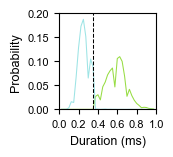


mean, sem excitatory cell waveform PTR:
0.44453274345353794 0.0009823209778073623
mean, sem IN waveform PTR:
0.6245140087498517 0.0033966498250377793
stat = -91.18738056878496
p_cells = 0.0


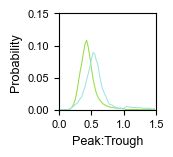

In [12]:
''' For putative interneurons vs. excitatory cells, plot distribution of waveform durations & peak/trough ratios (Figure S6B/C) '''

colors = ['#9DE4E5','#97DD43']

#STATS
print('\nn EXC cells, IN cells: ')
print(len(duratione), len(durationi))

#duration EXC vs. IN
print('\nmean, sem excitatory cell waveform duration:')
print(np.nanmean(duratione), stats.sem(duratione, nan_policy = 'omit')) 
print('mean, sem IN cell waveform duration:')
print(np.nanmean(durationi), stats.sem(durationi, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(duratione, durationi)
print('stat = '+ str(stat))
print('p_cells = ' + str(p_diff))

# Figure S6b
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(0,1,0.025)

#excitatory cells
bscore, bin_edges = np.histogram(duratione, bins = bins)
pdf = bscore / sum(bscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[1])

#inhibitory cells
score, bin_edges = np.histogram(durationi, bins = bins)
pdf = score / sum(score)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[0])

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Duration (ms)', fontsize = 9)
ax.set_xlim([0,1])
ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax.set_ylim([0,0.2])
ax.tick_params(labelsize = 8)
ax.vlines(0.35,0,ax.get_ylim()[1],linewidth = 0.75, color = 'k', linestyles = '--')

plt.savefig(save_folder + 'S6B.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6B.svg', dpi=400, bbox_inches='tight')
plt.show()

#STATS
#PTR EXC vs. IN
print('\nmean, sem excitatory cell waveform PTR:')
print(np.nanmean(PTRe), stats.sem(PTRe, nan_policy = 'omit')) 
print('mean, sem IN waveform PTR:')
print(np.nanmean(PTRi), stats.sem(PTRi, nan_policy = 'omit')) 
stat, p_diff = stats.ranksums(PTRe, PTRi)
print('stat = '+ str(stat))
print('p_cells = ' + str(p_diff))

# Plot Figure S6c
fig, ax = plt.subplots(figsize = (1.25,1.25))
bins = np.arange(0,1.5,0.025)

#excitatory cells
bscore, bin_edges = np.histogram(PTRe, bins = bins)
pdf = bscore / sum(bscore)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[1])

#inhibitory cells
score, bin_edges = np.histogram(PTRi, bins = bins)
pdf = score / sum(score)

ax.plot(bin_edges[1:], pdf, linewidth = 0.75, color = colors[0])

#format plot
ax.set_ylabel('Probability', fontsize = 9)
ax.set_xlabel('Peak:Trough', fontsize = 9)
ax.set_xlim([0,1.5])
ax.set_xticks([0,0.5,1.0,1.5])
ax.set_ylim([0,0.15])
ax.tick_params(labelsize = 8)
plt.savefig(save_folder + 'S6C.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6C.svg', dpi=400, bbox_inches='tight')
plt.show()


In [46]:
''' Gather Session Average IN Waveform Properties by Age Group '''

# pooling arrays
PTRa = []
PTRma = []
PTRy = []
FRa = []
FRma = []
FRy = []
widtha = []
widthma = []
widthy = []
durationa = []
durationma = []
durationy = []

#session arrays
sPTR = []
sFR = []
sduration = []
swidth = []
sint = []
mint = []

allwidth = []
allduration = []
allFR = []

for m, session in zip(mice,sessions):
    
    seshcount = 1 #should actually be 1 
    ints = []
    cells = []
    widths = []
    durations = []
    frs = []
    
    for s in session:
        d = data[m][s]
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        metric_file_name = m + '_' + str(seshcount) + '_metrics.csv'
        cell_IDs = raw.item().get('cellsfil')
        
        # load waveform parameters of interest for good cells only
        metrics = pd.read_csv(metrics_folder + metric_file_name)
        gcmetrics = metrics[metrics['cluster_id'].isin(list(cell_IDs))]
        duration = np.asarray(gcmetrics['duration'])
        PTR = np.asarray(gcmetrics['PT_ratio'])
        halfwidth = np.asarray(gcmetrics['halfwidth'])
        recslope = np.asarray(gcmetrics['recovery_slope'])
        firingrate = np.asarray(gcmetrics['firing_rate'])
        
        #get file name & load int file
        intn_file = 'intn_' + m + '_' + s + '.npy'
        d['intn'] = np.load(save_folder + intn_file, allow_pickle = True)
        intn = d['intn'].astype(bool)
        
        #collect data to be pooled across animals
        ints = np.append(ints, np.sum(intn))
        cells = np.append(cells, len(cell_IDs))
        widths = np.append(widths, halfwidth[intn])
        durations = np.append(durations, duration[intn])
        frs = np.append(frs, firingrate[intn])
        
        #save out session values
        sint = np.append(sint, 100*np.sum(intn)/len(cell_IDs))
        sPTR = np.append(sPTR, np.mean(PTR[intn]))
        sFR = np.append(sFR, np.mean(firingrate[intn]))
        swidth = np.append(swidth, np.nanmean(halfwidth[intn]))
        sduration = np.append(sduration, np.mean(duration[intn]))
        
        #collect data to be pooled across all sessions, animals in age groups
        if m in all_aged_mice:
            PTRa = np.append(PTRa, PTR[intn])
            FRa = np.append(FRa, firingrate[intn])
            widtha = np.append(widtha, halfwidth[intn])
            durationa = np.append(durationa, duration[intn])
        elif m in all_MA_mice:
            PTRma = np.append(PTRma, PTR[intn])
            FRma = np.append(FRma, firingrate[intn])
            widthma = np.append(widthma, halfwidth[intn])
            durationma = np.append(durationma, duration[intn])
        else:
            PTRy = np.append(PTRy, PTR[intn])
            FRy = np.append(FRy, firingrate[intn])
            widthy = np.append(widthy, halfwidth[intn])
            durationy = np.append(durationy, duration[intn])
            
        seshcount += 1
        
    mint = np.append(mint, (100* np.sum(ints) / np.sum(cells)))
    allwidth = np.append(allwidth, widths)
    allduration = np.append(allduration, durations)
    allFR = np.append(allFR, frs)

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Python\AppData\Local\Temp\ipykernel_10092\162676964.py:71: RuntimeWarning: Mean of empty slice
  swidth = np.append(swidth, np.nanmean(halfwidth[intn]))


In [14]:
''' Find where I will have NaNs due to 0% INs in a given session'''
nan_idx = np.where((sint == 0))[0]

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sindIN = np.setdiff1d(y_sind, nan_idx)
ma_sindIN = np.setdiff1d(ma_sind, nan_idx)
age_sindIN = np.setdiff1d(age_sind, nan_idx)

# Adjust colormaps for all thresholds
yidx = []
maidx = []
aidx = []
for i in nan_idx:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_youngIN = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_maIN = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldIN = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessionIN = [col_session_youngIN, col_session_maIN, col_session_oldIN]      

# This will fix how session stats & box plots are plotted, ensuring color schemes are adjusted.

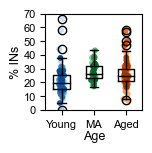

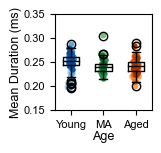

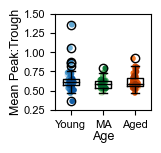

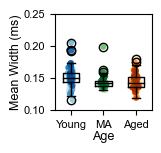

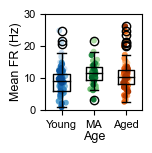

In [15]:
''' Plot Figure S6D Panels (IN Density & Waveform Properties) '''

# set up handles
from itertools import repeat
handles = []
percint = [mint[y_ind], mint[ma_ind], mint[age_ind]]
for i in range(len(percint)):
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))

#Plot Figure S6d (first)
fig, ax = plt.subplots(figsize = (1.25,1.25))
percint = [sint[y_sind], sint[ma_sind], sint[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(percint, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(percint)):
    y = percint[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i][:len(y)], edgecolors = col_session[i][:len(y)], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% INs', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,70])
ax.set_yticks([0,10,20,30,40,50,60,70])
plt.savefig(save_folder + 'S6Dfirst.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Dfirst.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (second)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intdur = [sduration[y_sindIN], sduration[ma_sindIN], sduration[age_sindIN]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(intdur, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intdur)):
    y = intdur[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Duration (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.15,0.35])
ax.set_yticks([0.15,0.20,0.25,0.30,0.35])
plt.savefig(save_folder + 'S6Dsecond.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Dsecond.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (middle)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intPTR = [sPTR[y_sindIN], sPTR[ma_sindIN], sPTR[age_sindIN]]
plt.boxplot(intPTR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intPTR)):
    y = intPTR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Peak:Trough', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.25, 1.50])
ax.set_yticks([0.25,0.50,0.75,1.0,1.25,1.50])
plt.savefig(save_folder + 'S6Dmiddle.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Dmiddle.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (fourth)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intwidth = [swidth[y_sindIN], swidth[ma_sindIN], swidth[age_sindIN]]
plt.boxplot(intwidth, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intwidth)):
    y = intwidth[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Width (ms)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0.10,0.25])
ax.set_yticks([0.10,0.15,0.20,0.25])
plt.savefig(save_folder + 'S6Dfourth.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Dfourth.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6D (last)
fig, ax = plt.subplots(figsize = (1.25,1.25))
intFR = [sFR[y_sindIN], sFR[ma_sindIN], sFR[age_sindIN]]
plt.boxplot(intFR, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(intFR)):
    y = intFR[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionIN[i], edgecolors = col_sessionIN[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean FR (Hz)', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,30])
ax.set_yticks([0,10,20,30])
plt.savefig(save_folder + 'S6Dlast.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Dlast.svg', dpi=400, bbox_inches='tight')
plt.show()

In [16]:
'''Statistics for Multiple Comparisons for IN Density (Figure S6D (first))'''

print('n young, MA, aged sessions: ')
print(len(y_sind),len(ma_sind), len(age_sind))

print('\n%intyoung ± SEM; %int_MA ± SEM; %int_old ± SEM')
print(str(np.round(np.mean(sint[y_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[y_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sint[ma_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[ma_sind]), 4)) + ' ; ' 
      + str(np.round(np.mean(sint[age_sind]), 4)) + ' ± ' + str(np.round(stats.sem(sint[age_sind]), 4)))

stat, p_diff = stats.kruskal(sint[y_sind],sint[ma_sind],sint[age_sind])
print('KW stat = ' + str(stat))
print('p_%intsession = ' + str(p_diff))

import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind,ma_sind,age_sind))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Percentint = list(sint[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Percentint))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','percentint'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentint', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions: 
98 58 97

%intyoung ± SEM; %int_MA ± SEM; %int_old ± SEM
21.2188 ± 0.9206 ; 27.3493 ± 0.8074 ; 26.2412 ± 0.8678
KW stat = 39.214030539662346
p_%intsession = 3.053384254495053e-09


,1.0,2.0,3.0
1.0,1.000000e+00,1.182298e-08,4.928001e-07
2.0,1.182298e-08,1.000000e+00,1.316514e-01
3.0,4.928001e-07,1.316514e-01,1.000000e+00


In [17]:
'''Statistics for Multiple Comparisons for IN Waveform Duration (Figure S6D (second))'''

print('\nn young, MA, aged w/ INs: ')
print(len(y_sindIN),len(ma_sindIN), len(age_sindIN))

print('\nDurationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM')
print(str(np.round(np.mean(sduration[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sduration[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sduration[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sduration[y_sindIN],sduration[ma_sindIN],sduration[age_sindIN])
print('KW stat = ' + str(stat))
print('p_durationsession = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindIN,ma_sindIN,age_sindIN))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Duration = list(sduration[allidx])
PTR = list(sPTR[allidx])
Width = list(swidth[allidx])
Meanfr = list(sFR[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Duration, PTR, Width, Meanfr))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','duration','ptr','width', 'meanfr'])
df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'duration', group_col = 'AgeGroup', p_adjust = 'holm')


n young, MA, aged w/ INs: 
97 58 97

Durationyoung ± SEM; Duration_MA ± SEM; Duration_old ± SEM
0.2481 ± 0.0018 ; 0.2406 ± 0.0019 ; 0.2402 ± 0.0016
KW stat = 22.58872170239936
p_durationsession = 1.2442894122603834e-05


,1.0,2.0,3.0
1.0,1.000000,0.000136,0.000063
2.0,0.000136,1.000000,0.764698
3.0,0.000063,0.764698,1.000000


In [18]:
'''Statistics for Multiple Comparisons for IN Waveform PTR (Figure S6D (middle))'''

print('\nPTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM')
print(str(np.round(np.mean(sPTR[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sPTR[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sPTR[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sPTR[y_sindIN],sPTR[ma_sindIN],sPTR[age_sindIN])
print('KW stat = ' + str(stat))
print('p_PTRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'ptr', group_col = 'AgeGroup', p_adjust = 'holm')


PTRyoung ± SEM; PTR_MA ± SEM; PTR_old ± SEM
0.6281 ± 0.0121 ; 0.5905 ± 0.0083 ; 0.6166 ± 0.0079
KW stat = 5.830669281773567
p_PTRsession = 0.05418589518262913


,1.0,2.0,3.0
1.0,1.000000,0.059076,0.66266
2.0,0.059076,1.000000,0.10001
3.0,0.662660,0.100010,1.00000


In [19]:
'''Statistics for Multiple Comparisons for IN Waveform Width (Figure S6D (fourth))'''

print('\nWidthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM')
print(str(np.round(np.mean(swidth[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(swidth[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(swidth[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(swidth[y_sindIN],swidth[ma_sindIN],swidth[age_sindIN])
print('KW stat = ' + str(stat))
print('p_widthsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'width', group_col = 'AgeGroup', p_adjust = 'holm')


Widthyoung ± SEM; Width_MA ± SEM; Width_old ± SEM
0.1503 ± 0.0015 ; 0.1431 ± 0.0013 ; 0.1433 ± 0.0012
KW stat = 21.48964678446369
p_widthsession = 2.155671061950531e-05


,1.0,2.0,3.0
1.0,1.000000,0.000147,0.000143
2.0,0.000147,1.000000,0.651504
3.0,0.000143,0.651504,1.000000


In [20]:
'''Statistics for Multiple Comparisons for IN Waveform Mean FR (Figure S6D (last))'''

print('\nFRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM')
print(str(np.round(np.mean(sFR[y_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[y_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[ma_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[ma_sindIN]), 4)) + ' ; ' 
      + str(np.round(np.mean(sFR[age_sindIN]), 4)) + ' ± ' + str(np.round(stats.sem(sFR[age_sindIN]), 4)))

stat, p_diff = stats.kruskal(sFR[y_sindIN],sFR[ma_sindIN],sFR[age_sindIN])
print('KW stat = ' + str(stat))
print('p_FRsession = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'meanfr', group_col = 'AgeGroup', p_adjust = 'holm')


FRyoung ± SEM; FR_MA ± SEM; FR_old ± SEM
9.0683 ± 0.4352 ; 11.4235 ± 0.424 ; 10.7849 ± 0.4427
KW stat = 18.582582788134573
p_FRsession = 9.222388596693254e-05


,1.0,2.0,3.0
1.0,1.000000,0.000062,0.010702
2.0,0.000062,1.000000,0.057326
3.0,0.010702,0.057326,1.000000


In [47]:
''' Define a List of Sex, Mouse ID, Session Count, Age for each IN'''

import statsmodels.api as sm
import statsmodels.formula.api as smf

csex = []
cmice = []
ccount = []
cage = []
cidx = []
ctask = [] 

totalcells = 0
for m, session in zip(mice, sessions):
    
    msex = np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Sex'])
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(tdqm(session)):
        
        d = data[m][s]
        
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        cell_IDs = raw.item().get('cellsfil')
    
        intn = d['intn'].astype(bool)
        INs = cell_IDs[intn]
        
        for j, c in enumerate(INs):
            cidx = np.append(cidx, totalcells)
            csex = np.append(csex, msex)
            cmice = np.append(cmice, m)
            ccount = np.append(ccount, (i + 1))
            cage = np.append(cage, age)
            
            totalcells += 1

#gather fixed effects into lists
Animal_ID = list(cmice)
Session = list(ccount)
Sex = list(csex)
Age_Group = list(cage)
Cell_ID = list(cidx)
Widths = list(allwidth)
Durations = list(allduration)
MeanFRs = list(allFR)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     MeanFR     
No. Observations:      15120       Method:                 REML       
No. Groups:            45          Scale:                  43.5541    
Min. group size:       53          Log-Likelihood:         -59939.2448
Max. group size:       592         Converged:              Yes        
Mean group size:       336.0                                          
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   11.476    0.943 12.170 0.000  9.628 13.324
C(AgeGroup)[T.2.0]           2.592    1.309  1.980 0.048  0.026  5.158
C(AgeGroup)[T.3.0]           0.140    0.890  0.157 0.875 -1.604  1.884
C(Sex)[T.M]                  0.561    1.297  0.432 0.666 -1.982  3.104
C(Cohort)[T.B]         

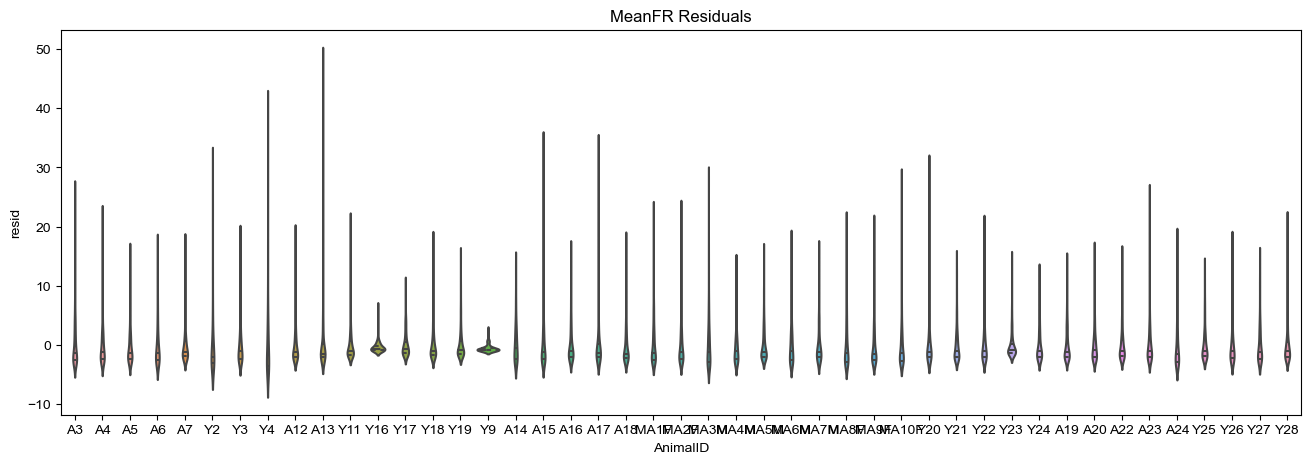

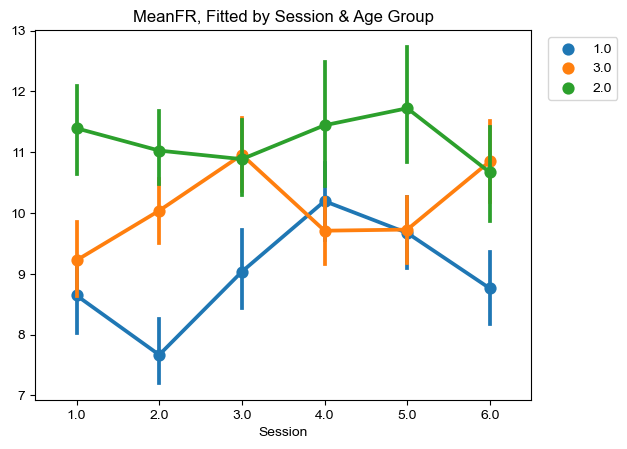

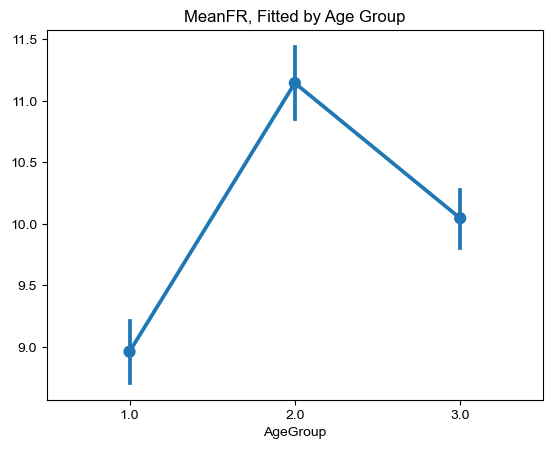

Raw Data Mean across All Sessions by Animal:
AnimalID
A12       8.526049
A13       8.808980
A14      12.404641
A15      11.341271
A16       9.188301
A17       8.449816
A18       9.581167
A19       9.288628
A20       9.656111
A22       8.540844
A23       9.520411
A24      12.585674
A3       11.554592
A4       11.290430
A5       10.392228
A6       12.348670
A7        8.258218
MA10F    11.006996
MA1F     10.453596
MA2F     10.794969
MA3M     15.082032
MA4M     11.382505
MA5M      8.598570
MA6M     12.390069
MA7M     10.363725
MA8F     12.078740
MA9F     10.444430
Y11       6.865176
Y16       2.348043
Y17       6.959112
Y18       8.197104
Y19       6.337407
Y2       14.416208
Y20       7.941983
Y21       9.339429
Y22       9.573594
Y23       5.517004
Y24       9.078200
Y25       8.756183
Y26       9.460636
Y27      10.284418
Y28       9.196297
Y3       10.838896
Y4       18.300427
Y9        1.574522

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12       8.483430
A13       8.76

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Duration  
No. Observations:      15120       Method:                 ML        
No. Groups:            45          Scale:                  0.0012    
Min. group size:       53          Log-Likelihood:         21560.9000
Max. group size:       592         Converged:              Yes       
Mean group size:       336.0                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.244    0.004 61.384 0.000  0.236  0.252
C(AgeGroup)[T.2.0]         -0.008    0.006 -1.379 0.168 -0.018  0.003
C(AgeGroup)[T.3.0]         -0.008    0.004 -2.130 0.033 -0.016 -0.001
C(Sex)[T.M]                 0.004    0.005  0.834 0.404 -0.006  0.015
C(Cohort)[T.B]             -0.005   

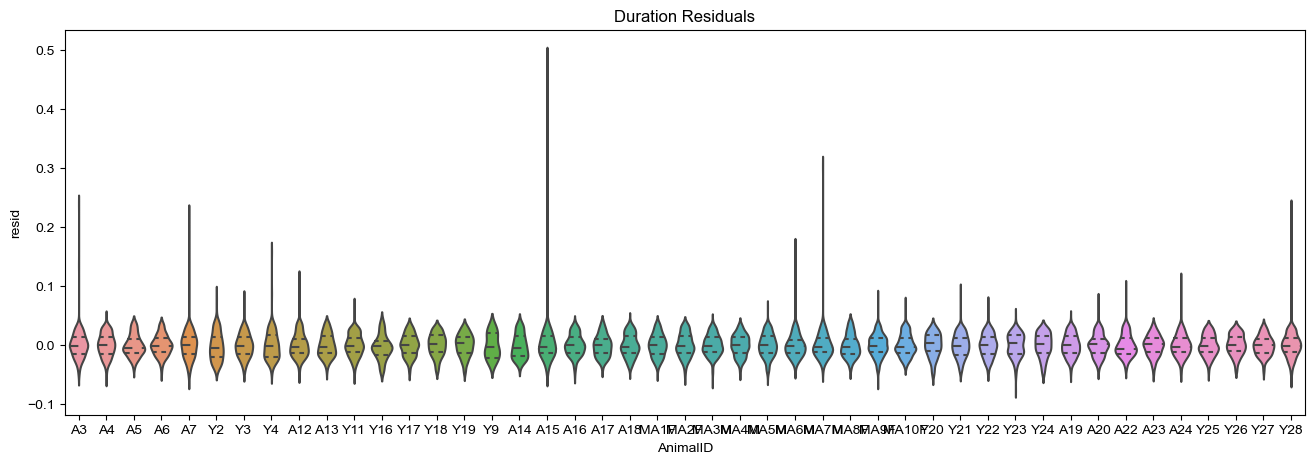

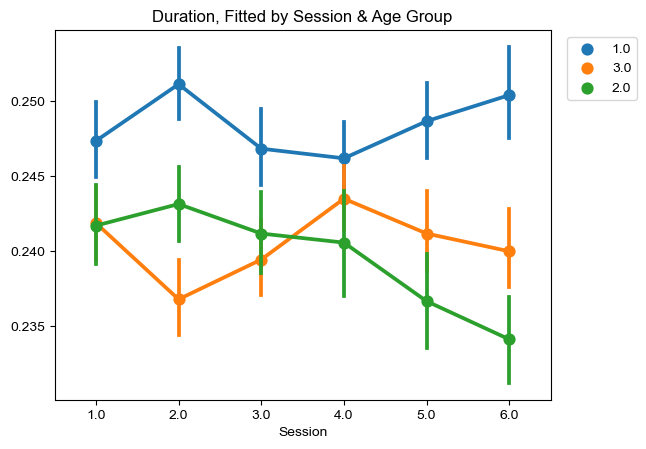

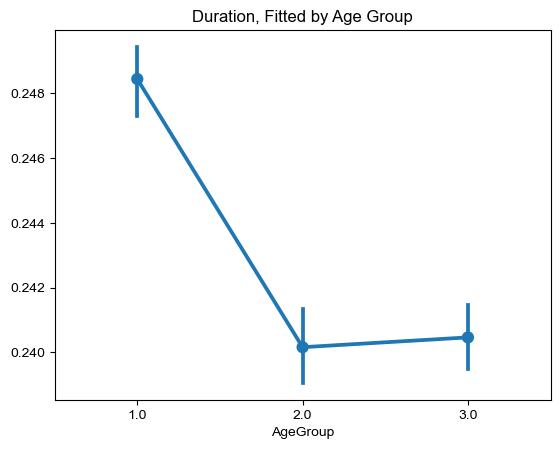

Raw Data Mean across All Sessions by Animal:
AnimalID
A12      0.230414
A13      0.230242
A14      0.227473
A15      0.244008
A16      0.247900
A17      0.229532
A18      0.242786
A19      0.245458
A20      0.243512
A22      0.236212
A23      0.239915
A24      0.240506
A3       0.251393
A4       0.250323
A5       0.232243
A6       0.237772
A7       0.250892
MA10F    0.243036
MA1F     0.234550
MA2F     0.241627
MA3M     0.248311
MA4M     0.244835
MA5M     0.242218
MA6M     0.235113
MA7M     0.240854
MA8F     0.225671
MA9F     0.239383
Y11      0.254174
Y16      0.216084
Y17      0.245790
Y18      0.255887
Y19      0.250338
Y2       0.217605
Y20      0.250727
Y21      0.253654
Y22      0.249046
Y23      0.250871
Y24      0.258517
Y25      0.252427
Y26      0.263525
Y27      0.244697
Y28      0.253073
Y3       0.234327
Y4       0.236671
Y9       0.240239

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12      0.230647
A13      0.230446
A14      0.228855
A15      0.243943
A16   

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Width     
No. Observations:      15120       Method:                 REML      
No. Groups:            45          Scale:                  0.0010    
Min. group size:       53          Log-Likelihood:         22375.1313
Max. group size:       592         Converged:              Yes       
Mean group size:       336.0                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.142    0.003 46.541 0.000  0.136  0.148
C(AgeGroup)[T.2.0]         -0.006    0.004 -1.491 0.136 -0.015  0.002
C(AgeGroup)[T.3.0]         -0.005    0.003 -1.622 0.105 -0.011  0.001
C(Sex)[T.M]                -0.001    0.004 -0.195 0.845 -0.008  0.007
C(Cohort)[T.B]              0.005   

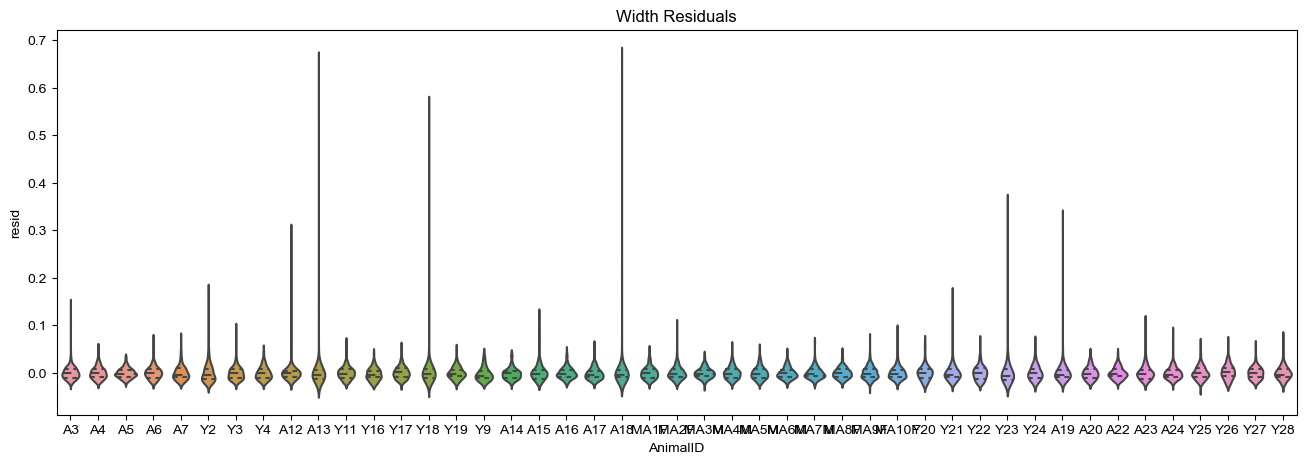

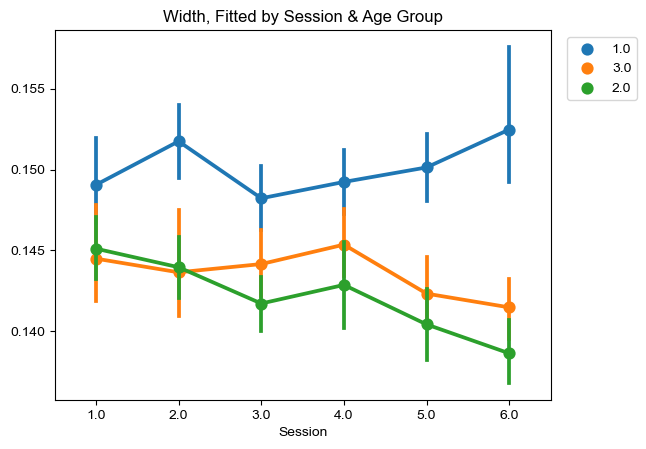

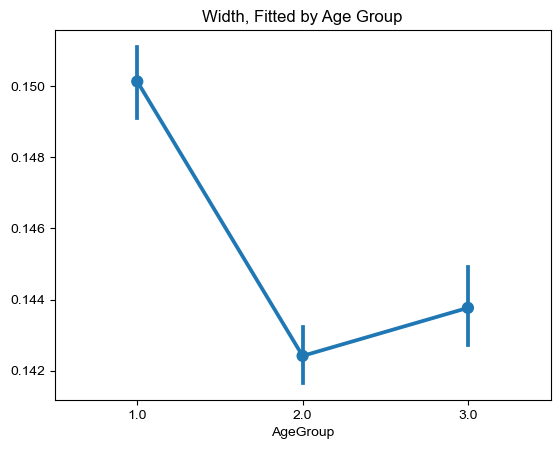

Raw Data Mean across All Sessions by Animal:
AnimalID
A12      0.138290
A13      0.149983
A14      0.137353
A15      0.146675
A16      0.147174
A17      0.135056
A18      0.150881
A19      0.148943
A20      0.142376
A22      0.142643
A23      0.146739
A24      0.149319
A3       0.142448
A4       0.140753
A5       0.134210
A6       0.141527
A7       0.135229
MA10F    0.145195
MA1F     0.141377
MA2F     0.139305
MA3M     0.143055
MA4M     0.145751
MA5M     0.142644
MA6M     0.138455
MA7M     0.140324
MA8F     0.139509
MA9F     0.144785
Y11      0.142269
Y16      0.131265
Y17      0.148318
Y18      0.159043
Y19      0.146461
Y2       0.136530
Y20      0.153821
Y21      0.151413
Y22      0.148827
Y23      0.172478
Y24      0.155384
Y25      0.150954
Y26      0.164584
Y27      0.152191
Y28      0.148065
Y3       0.140245
Y4       0.140171
Y9       0.135539

Fitted Data Mean across All Sessions by Animal:
AnimalID
A12      0.138468
A13      0.149435
A14      0.138796
A15      0.146705
A16   

In [53]:
''' Run LMM on IN FR, Halfwidth, Duration Report out Fitted Values for Figure 7 & 8 '''

#gather dataframe
tuples = list(zip(Animal_ID, Session, Cell_ID, Sex, Age_Group, Cohort, Widths, Durations, MeanFRs))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session','Cell_ID', 'Sex', 'AgeGroup', 'Cohort','Width','Duration','MeanFR'])

#handle NaNs
df = df.dropna()

# MeanFR Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mMeanFR = smf.mixedlm('MeanFR ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(mMeanFR.summary())
print(mMeanFR.wald_test_terms(scalar = False))
#print(mMeanFR.aic)
#print(mMeanFR.bic)

#plots of residuals
df['resid'] = mMeanFR.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('MeanFR Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mMeanFR.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('MeanFR, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mMeanFR.fittedvalues)
plt.title('MeanFR, Fitted by Age Group')
plt.show()

df['fitted'] = mMeanFR.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['MeanFR'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')

# Duration Dependent (Required ML to Converge)
vc = {'cells':'0 + C(Cell_ID)'}
mDuration = smf.mixedlm('Duration ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = False)
print(mDuration.summary())
print(mDuration.wald_test_terms(scalar = False))
#print(mDuration.aic)
#print(mDuration.bic)

#plots of residuals
df['resid'] = mDuration.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Duration Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mDuration.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Duration, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mDuration.fittedvalues)
plt.title('Duration, Fitted by Age Group')
plt.show()

df['fitted'] = mDuration.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Duration'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')

# Width  Dependent
vc = {'cells':'0 + C(Cell_ID)'}
mWidth = smf.mixedlm('Width ~ 1 + C(AgeGroup) + C(Sex) + C(Cohort) + Session + Session:C(AgeGroup)', groups = 'AnimalID', re_formula = '1', vc_formula = vc,
                     data=df).fit(reml = True)
print(mWidth.summary())
print(mWidth.wald_test_terms(scalar = False))
#print(mWidth.aic)
#print(mWidth.bic)

#plots of residuals
df['resid'] = mWidth.resid
fig, ax = plt.subplots(figsize = (16,5))
sns.violinplot(data = df, x = 'AnimalID', y = 'resid', inner = 'quartile', ax = ax)
plt.title('Width Residuals')
plt.show()

#plot fitted values
hue_order = [1.0, 3.0, 2.0]
sns.pointplot(x = df['Session'], y = mWidth.fittedvalues, hue = df['AgeGroup'], hue_order = hue_order)
plt.title('Width, Fitted by Session & Age Group')
plt.legend(bbox_to_anchor = (1.02,1), loc = 2)
plt.show()

sns.pointplot(x = df['AgeGroup'], y = mWidth.fittedvalues)
plt.title('Width, Fitted by Age Group')
plt.show()

df['fitted'] = mWidth.fittedvalues
animalgrouped = df.groupby(['AnimalID'])

print('Raw Data Mean across All Sessions by Animal:')
print(animalgrouped['Width'].mean().to_string(index=True))

print('\nFitted Data Mean across All Sessions by Animal:')
print(animalgrouped['fitted'].mean().to_string(index=True))

# No sig. session x age effects... Therefore, not reporting change in mean across sessions
#print('\nFitted Data Mean across All Sessions by Animal:')
#print('First Three: ')
#print(df.loc[df['Session'] <= 3].groupby(['AnimalID'])['fitted'].mean().to_string(index = True))
#print('Last Three: ')

# Classify speed-tuned interneurons, speed-only cells & speed-tuned grid cells. 

In [21]:
'''Load Scores & Save Booleans of Negative & Positively Modulated Speed Cells 
  
 NOTE: shuffled scores are produced by the notebook "Shuffle Procedure." Please run that for all sessions before proceeding here.

'''  

P99score = []
P99stabscore = []
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        realspeedscore_file = 'realinstspeedscore_' + m + '_' + s + '.npy'
        realspeedstabscore_file = 'realspeedstabscore_' + m + '_' + s + '.npy'
        shufinstspeedscore_file = 'shufinstspeedscore_' + m + '_' + s + '.npy'
        shufspeedstabscore_file = 'shufspeedstabscore_' + m + '_' + s + '.npy'
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        
        #Load stuff & get data relevant to classification
        d['speedscore'] = np.load(fig6_folder + realspeedscore_file)
        d['speedstabscore'] = np.load(fig6_folder + realspeedstabscore_file)
        d['shufspeedscore'] = np.load(shuffload_folder1 + shufinstspeedscore_file, allow_pickle = True) 
        d['shufspeedstabscore'] = np.load(shuffload_folder2 + shufspeedstabscore_file, allow_pickle = True) 
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        shufspeedscore = d['shufspeedscore']
        shufspeedstabscore = d['shufspeedstabscore']
        realspeed_score = d['speedscore'] 
        realspeedstab_score = d['speedstabscore'] 
        cell_IDs = raw.item().get('cellsfil')
        
        speedcell99 = []
        speedcell1 = []
        
        #Classify excitatory, positively & negatively modulated speed cells
        for i, c in enumerate(cell_IDs):
            dist = abs(shufspeedscore[:,i])
            P99 = np.percentile(dist,99)
            
            dist2 = abs(shufspeedstabscore[:,i])
            sP99 = np.percentile(dist2,99)
            
            P99stabscore = np.append(P99stabscore, sP99)
            P99score = np.append(P99score, P99)

            if (abs(realspeed_score[i]) >= P99) & (abs(realspeedstab_score[i]) >= sP99):
                if realspeed_score[i] >= 0: # pos mod P99 cell
                    speedcell99 = np.append(speedcell99, True)
                    speedcell1 = np.append(speedcell1, False)
                else: # neg mod P99 cell
                    speedcell99 = np.append(speedcell99, False)
                    speedcell1 = np.append(speedcell1, True) 
            else:
                speedcell99 = np.append(speedcell99, False)
                speedcell1 = np.append(speedcell1, False) 

        speedcell99 = np.asarray(speedcell99).astype(bool)
        speedcell1 = np.asarray(speedcell1).astype(bool)
                
        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedcell99'] = speedcell99
        d['speedcell1'] = speedcell1


In [22]:
 '''Load Scores & Save Booleans of Negative & Positively Speed Modulated Interneurons: '''

for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        
        #load speed tuned cells
        
        speedcell99 = d['speedcell99'].astype(bool)
        speedcell1 = d['speedcell1'].astype(bool)
        
        # ID speed modulated interneurons
        speedint99 = []
        speedint1 = []
        for i, c in enumerate(cell_IDs):
            if (intn[i] == True):
                if (speedcell99[i] == True):
                    speedint99 = np.append(speedint99, True)
                    speedint1 = np.append(speedint1, False)
                elif (speedcell1[i] == True): 
                    speedint99 = np.append(speedint99, False)
                    speedint1 = np.append(speedint1, True)
                else:
                    speedint99 = np.append(speedint99, False)
                    speedint1 = np.append(speedint1, False)  
            else:
                speedint99 = np.append(speedint99, False)
                speedint1 = np.append(speedint1, False)

        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedint99'] = speedint99.astype(bool)
        d['speedint1'] = speedint1.astype(bool)

In [23]:
 '''Load Scores & Save Booleans of Negative & Positively ONLY Speed Modulated Excitatory Cells
 
Note: Figure 2/S3 and 5 notebooks must be run before this. 

'''
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99'].astype(bool)
        speedcell1 = d['speedcell1'].astype(bool)
        
        # load in spatial cell booleans to exclude spatially tuned cells from speed cells    
        if (m in cohorta_mice) | (m in cohortb_mice):
            spatial_folder = fig5_folder
            
            sparsityscore_file = 'sparsityscores_' + m + '_' + s + '.npy'
            spatialcoherencescore_file = 'spatialcoherencescores_' + m + '_' + s + '.npy'
            shufsparsityscore_file = 'shufsparsityscores_' + m + '_' + s + '.npy'
            shufspatialcoherencescore_file = 'shufspatialcoherencescores_' + m + '_' + s + '.npy'
            
            sparsity_scores = np.load(spatial_folder + sparsityscore_file, allow_pickle=True)
            spatialcoherence_scores = np.load(spatial_folder + spatialcoherencescore_file, allow_pickle=True)
            shuffsparsityscores = np.load(shuffload_folder3 + shufsparsityscore_file, allow_pickle=False)
            shuffspatialcoherencescores = np.load(shuffload_folder4 + shufspatialcoherencescore_file, allow_pickle=False)
        else:
            spatial_folder = figs2_folder
            
            sparsityascore_file = 'sparsityascores_' + m + '_' + s + '.npy'
            spatialacoherencescore_file = 'spatialacoherencescores_' + m + '_' + s + '.npy' 
            shufsparsityascore_file = 'shufsparsityascores_' + m + '_' + s + '.npy'
            shufspatialacoherencescore_file = 'shufspatialacoherencescores_' + m + '_' + s + '.npy'
            
            sparsity_scores = np.load(spatial_folder + sparsityascore_file, allow_pickle=True)
            spatialcoherence_scores = np.load(spatial_folder + spatialacoherencescore_file, allow_pickle=True)
            shuffsparsityscores = np.load(shuffload_folder5 + shufsparsityascore_file, allow_pickle=False)
            shuffspatialcoherencescores = np.load(shuffload_folder6 + shufspatialacoherencescore_file, allow_pickle=False)
        
        spatialcell99_file = 'spatialcell99_' + m + '_' + s + '.npy'  
        spatialcell99 = np.load(spatial_folder + spatialcell99_file)
        
        #also define P95 spatial cells to exclude more weakly spatially tuned cells
        spatialcell95 = []
        for i, c in enumerate(cell_IDs): 
            dist1 = shuffspatialcoherencescores[:,i]
            P951 = np.percentile(dist1,95)

            dist2 = shuffsparsityscores[:,i]
            P952 = np.percentile(dist2,95)

            if intn[i] == True:
                spatialcell95 = np.append(spatialcell95, False)
            elif (spatialcoherence_scores[i] > P951) & (sparsity_scores[i] > P952):
                spatialcell95 = np.append(spatialcell95, True)
            else:
                spatialcell95 = np.append(spatialcell95, False)
        spatialcell95 = np.asarray(spatialcell95).astype(bool)
        
        #ID excitatory cells that are speed tuned but not spatially tuned
        speedonly99 = []
        speedonly1 = []
        for i, c in enumerate(cell_IDs):
            if (intn[i] == False) and (spatialcell95[i] == False) and (spatialcell99[i] == False):
                if (speedcell99[i] == True):
                    speedonly99 = np.append(speedonly99, True)
                    speedonly1 = np.append(speedonly1, False)
                elif (speedcell1[i] == True): 
                    speedonly99 = np.append(speedonly99, False)
                    speedonly1 = np.append(speedonly1, True)
                else:
                    speedonly99 = np.append(speedonly99, False)
                    speedonly1 = np.append(speedonly1, False)  
            else:
                speedonly99 = np.append(speedonly99, False)
                speedonly1 = np.append(speedonly1, False)

        #save speed cell classification boolean as .npy file for easy access for all animals
        d['speedonly99'] = speedonly99.astype(bool)
        d['speedonly1'] = speedonly1.astype(bool)

In [24]:
'''Save Booleans of Positively Speed Modulated Grid Cells (Split Maze Sessions)'''  
    
for m, session in zip(mice,sessions):
    for s in session:
        d = data[m][s]
    
        #get file names
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99'].astype(bool)
        
        #load grid cell boolean for Split Maze Sessions, make dummy array for RF sessions
        if (m in cohortc_mice) | (m in cohortd_mice):
            gridcell_file = 'gridcell__' + m + '_' + s + '.npy'
            gridcell = np.load(figs2_folder + gridcell_file)
        else:
            gridcell = np.full(len(cell_IDs),False)
        gridcell = gridcell.astype(bool) 
        
        #ID excitatory cells that are speed tuned but not spatially tuned
        speedgrid99 = []
        for i, c in enumerate(cell_IDs):
            if (intn[i] == False) and (gridcell[i] == True):
                if (speedcell99[i] == True):
                    speedgrid99 = np.append(speedgrid99, True)
                else:
                    speedgrid99 = np.append(speedgrid99, False)
            else:
                speedgrid99 = np.append(speedgrid99, False)  
            
        d['speedgrid99'] = speedgrid99.astype(bool)

# Examine density of all speed tuned cell types (Figures S6E)

In [25]:
'''Collect Density of Cell Types'''
#arrays for density of +/- speed cells 
sper99 = []
sper1 = []
speronly99 = []
speronly1 = []
sperint99 = []
spergrid99 = []
        
mper99 = []
mper1 = []

dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_99 = []
    m_1 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        
        #get dict-stored data & define lists of cell IDs for each speed tuned group
        cell_IDs = raw.item().get('cellsfil')
        intn = d['intn'].astype(bool)
        speedcell99 = d['speedcell99']
        speedcell1 = d['speedcell1']
        speedonly99 = d['speedonly99']
        speedonly1 = d['speedonly1']
        speedint99 = d['speedint99']
        speedgrid99 = d['speedgrid99']
        
        speedcells99 = cell_IDs[(speedcell99 == 1) & (intn == 0)] # + speed  
        speedcells1 = cell_IDs[(speedcell1 == 1) & (intn == 0)] # - speed
        speedonlycells99 = cell_IDs[speedonly99 == 1] # + speed only 
        speedonlycells1 = cell_IDs[speedonly1 == 1] # - speed only
        speedints99 = cell_IDs[speedint99 == 1] # speed grid cells
        speedgrids99 = cell_IDs[speedgrid99 == 1] # speed grid cells
        
        #get density among recorded units per session
        sper99 = np.append(sper99, 100*len(speedcells99)/len(cell_IDs))
        sper1 = np.append(sper1, 100*len(speedcells1)/len(cell_IDs))
        speronly99 = np.append(speronly99, 100*len(speedonlycells99)/len(cell_IDs))
        speronly1 = np.append(speronly1, 100*len(speedonlycells1)/len(cell_IDs))
        sperint99 = np.append(sperint99, 100*len(speedints99)/len(cell_IDs))
        
        if (m in cohortc_mice) | (m in cohortd_mice):
            spergrid99 = np.append(spergrid99, 100*len(speedgrids99)/len(cell_IDs))
        else:
            spergrid99 = np.append(spergrid99, np.nan)
        
        #pool data into session arrays    
        m_cells = np.append(m_cells, len(cell_IDs))
        m_99 = np.append(m_99, len(speedcells99))
        
    mper99 = np.append(mper99, 100*np.sum(m_99)/np.sum(m_cells))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

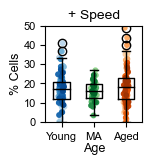

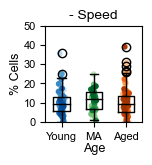

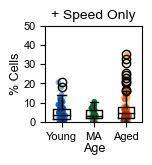

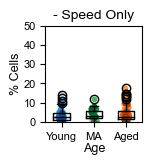

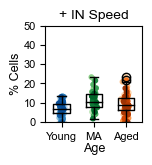

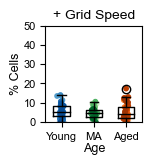

In [26]:
''' Plot Figure S6E '''

#set up handles
from itertools import repeat
handles = []
mper = [mper99[y_ind], mper99[ma_ind], mper99[age_ind]]

for i in range(len(mper)):    
    for c in col_animal[i][0]:
        dot = mlines.Line2D([],[], color = c, marker ='o', linestyle = 'None', markersize = 8)
        handles.append(dot)
        if c[0] == col_animal[1][0][9][0]: # adds white space so columns are color sorted
            l = mlines.Line2D([0],[0],color="w")
            handles.extend(repeat(l,7))
            
            
# Plot Figure S6E (first)
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [sper99[y_sind], sper99[ma_sind], sper99[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Efirst.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Efirst.svg', dpi=400, bbox_inches='tight')
plt.show()
      
# Plot Figure S6E (second)
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [sper1[y_sind], sper1[ma_sind], sper1[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Esecond.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Esecond.svg', dpi=400, bbox_inches='tight')
plt.show()
      
# Plot Figure S6E (third)
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [speronly99[y_sind], speronly99[ma_sind], speronly99[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Ethird.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Ethird.svg', dpi=400, bbox_inches='tight')
plt.show()

# Plot Figure S6E (fourth)
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [speronly1[y_sind], speronly1[ma_sind], speronly1[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Efourth.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Efourth.svg', dpi=400, bbox_inches='tight')
plt.show()

# Plot Figure S6E (last)
fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [sperint99[y_sind], sperint99[ma_sind], sperint99[age_sind]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session[i], edgecolors = col_session[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ IN Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Efifth.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Efifth.svg', dpi=400, bbox_inches='tight')
plt.show()

# Plot Figure S6E (last)

# Adjust y_sind, ma_sind, age_sind 
nanidx = np.isnan(spergrid99)
nan_idx = np.arange(0,len(nanidx))[nanidx]
y_sindgrid = np.setdiff1d(y_sind, nan_idx)
ma_sindgrid = np.setdiff1d(ma_sind, nan_idx)
age_sindgrid = np.setdiff1d(age_sind, nan_idx)
    
yidx = []
maidx = []
aidx = []
for i in nan_idx:
    yidx = np.append(yidx, np.where(y_sind == i)[0])
    maidx = np.append(maidx, np.where(ma_sind == i)[0])
    aidx = np.append(aidx, np.where(age_sind == i)[0])
    
col_session_younggrid = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid = [col_session_younggrid, col_session_magrid, col_session_oldgrid] 

fig, ax = plt.subplots(figsize = (1.25,1.25))
sper = [spergrid99[y_sindgrid], spergrid99[ma_sindgrid], spergrid99[age_sindgrid]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sper, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sper)):
    y = sper[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid[i], edgecolors = col_sessiongrid[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Grid Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('% Cells', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,50])
ax.set_yticks([0,10,20,30,40,50])
plt.savefig(save_folder + 'S6Elast.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Elast.svg', dpi=400, bbox_inches='tight')
plt.show()

In [27]:
'''Speed Cell Density Statistics with Multiple Comparisons by Session'''

print('n young, MA, aged sessions: ')
print(len(y_sind),len(ma_sind),len(age_sind))

print('\n+ Speed Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(sper99[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper99[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper99[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper99[age_sind]), 2)))

stat, p_diff = stats.kruskal(sper99[y_sind],sper99[ma_sind],sper99[age_sind])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#set up multiple comparisons
import statsmodels.api as sm
import scikit_posthocs as ph

#make into dataframe
seshmice = []
seshcount = []
seshage = []
for m, session in zip(mice, sessions):
    age =  np.array(animalmeta.loc[(animalmeta.Animal_ID == m),'Age_Group'])
    totalsesh = len(session)
    
    for i, s in enumerate(session):
        seshmice = np.append(seshmice, m)
        seshcount = np.append(seshcount, (i + 1))
        seshage = np.append(seshage, age)

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind,ma_sind,age_sind))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Percentneg = list(sper1[allidx])
Percentpos = list(sper99[allidx])
Percentonlyneg = list(speronly1[allidx])
Percentonlypos = list(speronly99[allidx])
Percentintpos = list(sperint99[allidx])
Percentgridpos = list(spergrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Percentneg, Percentpos,Percentonlyneg,Percentonlypos,Percentintpos,Percentgridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','percentneg','percentpos','percentonlyneg','percentonlypos','percentintpos','percentgridpos'])
#df = df.dropna(axis = 0)

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions: 
98 58 97

+ Speed Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
16.67 ± 0.77 ; 16.13 ± 0.64 ; 18.41 ± 0.95
KW stat = 1.7125177031199548
p_session = 0.4247481595070701


,1.0,2.0,3.0
1.0,1.000000,0.817741,0.756778
2.0,0.817741,1.000000,0.756778
3.0,0.756778,0.756778,1.000000


In [28]:
print('- Speed Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(sper1[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper1[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper1[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper1[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sper1[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sper1[age_sind]), 2)))

stat, p_diff = stats.kruskal(sper1[y_sind],sper1[ma_sind],sper1[age_sind])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentneg', group_col = 'AgeGroup', p_adjust = 'holm')

- Speed Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
10.11 ± 0.6 ; 11.02 ± 0.7 ; 10.52 ± 0.74
KW stat = 2.2139981137793443
p_session = 0.3305494342023059


,1.0,2.0,3.0
1.0,1.000000,0.538297,0.990844
2.0,0.538297,1.000000,0.538297
3.0,0.990844,0.538297,1.000000


In [29]:
print('+ Speed Only Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(speronly99[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly99[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speronly99[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly99[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speronly99[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly99[age_sind]), 2)))

stat, p_diff = stats.kruskal(speronly99[y_sind],speronly99[ma_sind],speronly99[age_sind])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentonlypos', group_col = 'AgeGroup', p_adjust = 'holm')

+ Speed Only Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
4.63 ± 0.41 ; 3.96 ± 0.35 ; 6.9 ± 0.76
KW stat = 4.00590709352918
p_session = 0.13493615386245852


,1.0,2.0,3.0
1.0,1.000000,0.835091,0.262845
2.0,0.835091,1.000000,0.262845
3.0,0.262845,0.262845,1.000000


In [30]:
print('- Speed Only Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(speronly1[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly1[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speronly1[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly1[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(speronly1[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(speronly1[age_sind]), 2)))

stat, p_diff = stats.kruskal(speronly1[y_sind],speronly1[ma_sind],speronly1[age_sind])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentonlyneg', group_col = 'AgeGroup', p_adjust = 'holm')

- Speed Only Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
3.25 ± 0.3 ; 3.59 ± 0.34 ; 4.19 ± 0.39
KW stat = 3.0449889253394775
p_session = 0.21816699819965096


,1.0,2.0,3.0
1.0,1.000000,0.375536,0.330865
2.0,0.375536,1.000000,0.948585
3.0,0.330865,0.948585,1.000000


In [31]:
print('+ IN Speed Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(sperint99[y_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperint99[y_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperint99[ma_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperint99[ma_sind]), 2)) + ' ; ' 
      + str(np.round(np.mean(sperint99[age_sind]), 2)) + ' ± ' + str(np.round(stats.sem(sperint99[age_sind]), 2)))

stat, p_diff = stats.kruskal(sperint99[y_sind],sperint99[ma_sind],sperint99[age_sind])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

#run post hoc tests
ph.posthoc_conover(df, val_col = 'percentintpos', group_col = 'AgeGroup', p_adjust = 'holm')

+ IN Speed Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
6.92 ± 0.35 ; 10.97 ± 0.63 ; 9.39 ± 0.48
KW stat = 29.055896945507357
p_session = 4.904470706403604e-07


,1.0,2.0,3.0
1.0,1.000000e+00,3.988494e-07,0.000227
2.0,3.988494e-07,1.000000e+00,0.042846
3.0,2.265491e-04,4.284631e-02,1.000000


In [32]:
print('n young, MA, aged Split Maze sessions: ')
print(len(y_sindgrid),len(ma_sindgrid),len(age_sindgrid))

print('+ Grid Speed Cell Density Results:')
print('speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM')
print(str(np.round(np.mean(spergrid99[y_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid99[y_sindgrid]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid99[ma_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid99[ma_sindgrid]), 2)) + ' ; ' 
      + str(np.round(np.mean(spergrid99[age_sindgrid]), 2)) + ' ± ' + str(np.round(stats.sem(spergrid99[age_sindgrid]), 2)))

stat, p_diff = stats.kruskal(spergrid99[y_sindgrid],spergrid99[ma_sindgrid],spergrid99[age_sindgrid])
print('KW stat = ' + str(stat))
print('p_speedcell1%session = ' + str(p_diff))

#run post hoc tests on non nan values
df = df.dropna(axis = 0)
ph.posthoc_conover(df, val_col = 'percentgridpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged Split Maze sessions: 
54 58 55
+ Grid Speed Cell Density Results:
speedcell%young ± SEM; speedcell%_MA ± SEM; speedcell%_old ± SEM
5.64 ± 0.46 ; 4.64 ± 0.3 ; 5.34 ± 0.57
KW stat = 2.1204642302870043
p_speedcell1%session = 0.34637540202227957


,1.0,2.0,3.0
1.0,1.000000,0.516155,0.526349
2.0,0.516155,1.000000,0.814270
3.0,0.526349,0.814270,1.000000


# Examine speed-FR slope of speed tuned cells not in Figure 6d (Figure S6F)

In [33]:
'''Collect Speed FR Slopes'''
# set up arrays for plotting by session 
sslope99 = []
sslope1 = []
sslopeint99 = []
sslopegrid99 = []
dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_99 = []
    m_1 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(fig6_folder + A_file)
        speed = behaviorfil[:,1]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        speedonly99 = d['speedonly99']
        speedonly1 = d['speedonly1']
        speedint99 = d['speedint99']
        speedgrid99 = d['speedgrid99']
        
        speedonlycells99 = cell_IDs[speedonly99 == 1] # + speed only 
        speedonlycells1 = cell_IDs[speedonly1 == 1] # - speed only
        speedints99 = cell_IDs[speedint99 == 1] # speed grid cells
        speedgrids99 = cell_IDs[speedgrid99 == 1] # speed grid cells
        
        #get slopes for each speed cell population
        slope99 = []
        for i, c in enumerate(speedonlycells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope99 = np.append(slope99,slopeFR) #FR/speed slope
            
        slope1 = []
        for i, c in enumerate(speedonlycells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slope1 = np.append(slope1,slopeFR) #FR/speed slope
            
        slopeint99 = []
        for i, c in enumerate(speedints99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slopeint99 = np.append(slopeint99,slopeFR) #FR/speed slope
            
        slopegrid99 = []
        for i, c in enumerate(speedgrids99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            #get slope/FR and convert to Hz/speed
            slopeFR, intFR, r_value, p_val, std_err = stats.linregress(speed, A[:,sdx])
            slopeFR = slopeFR/dt
            intFR = intFR/dt
            slopegrid99 = np.append(slopegrid99,slopeFR) #FR/speed slope
        
        #pool data into session arrays    
        sslope99 = np.append(sslope99, np.mean(slope99))
        sslope1 = np.append(sslope1, np.mean(slope1))
        sslopeint99 = np.append(sslopeint99, np.mean(slopeint99))
        sslopegrid99 = np.append(sslopegrid99, np.mean(slopegrid99))

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
''' Find where I will have NaNs due to 0% speed cells in a given'''
nan_idx99 = np.where((speronly99 == 0))[0]
nan_idx1 = np.where((speronly1 == 0))[0]
nan_idxint99 = np.where((sperint99 == 0))[0]
nan_idxgrid99 = np.union1d(nan_idx, np.where((spergrid99 == 0))[0]) 

# Adjust y_sind, ma_sind, age_sind for subsequent plots
y_sind99 = np.setdiff1d(y_sind, nan_idx99)
ma_sind99 = np.setdiff1d(ma_sind, nan_idx99)
age_sind99 = np.setdiff1d(age_sind, nan_idx99)

y_sind1 = np.setdiff1d(y_sind, nan_idx1)
ma_sind1 = np.setdiff1d(ma_sind, nan_idx1)
age_sind1 = np.setdiff1d(age_sind, nan_idx1)

y_sindint = np.setdiff1d(y_sind, nan_idxint99)
ma_sindint = np.setdiff1d(ma_sind, nan_idxint99)
age_sindint = np.setdiff1d(age_sind, nan_idxint99)

y_sindgrid99 = np.setdiff1d(y_sind, nan_idxgrid99)
ma_sindgrid99 = np.setdiff1d(ma_sind, nan_idxgrid99)
age_sindgrid99 = np.setdiff1d(age_sind, nan_idxgrid99)

# Adjust colormaps for all thresholds
yidx = []
maidx = []
aidx = []
for i in nan_idx99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young99 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma99 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old99 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session99 = [col_session_young99, col_session_ma99, col_session_old99] 

yidx = []
maidx = []
aidx = []
for i in nan_idx1:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_young1 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_ma1 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_old1 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_session1 = [col_session_young1, col_session_ma1, col_session_old1]       

yidx = []
maidx = []
aidx = []
for i in nan_idxint99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_youngint = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_maint = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldint = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessionint = [col_session_youngint, col_session_maint, col_session_oldint]

yidx = []
maidx = []
aidx = []
for i in nan_idxgrid99:
    yidx = np.append(yidx, np.where(y_sind == i)[0].astype(int))
    maidx = np.append(maidx, np.where(ma_sind == i)[0].astype(int))
    aidx = np.append(aidx, np.where(age_sind == i)[0].astype(int))
    
col_session_younggrid99 = np.delete(col_session_young, list(yidx.astype(int)), axis = 0)
col_session_magrid99 = np.delete(col_session_MA, list(maidx.astype(int)), axis = 0)
col_session_oldgrid99 = np.delete(col_session_old, list(aidx.astype(int)), axis = 0)
col_sessiongrid99 = [col_session_younggrid99, col_session_magrid99, col_session_oldgrid99]

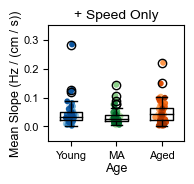

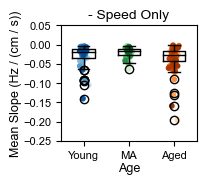

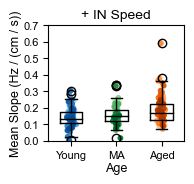

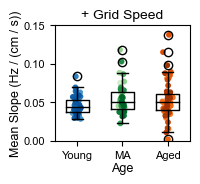

In [35]:
''' Plot Figure S6F '''

#Plot Figure S6F (first)
fig, ax = plt.subplots(figsize = (1.75,1.5))
sslope = [sslope99[y_sind99], sslope99[ma_sind99], sslope99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.05,0.35])
ax.set_yticks([0,0.1,0.2,0.3])
plt.savefig(save_folder + 'S6Ffirst.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Ffirst.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6F (second)
fig, ax = plt.subplots(figsize = (1.75,1.5))
sslope = [sslope1[y_sind1], sslope1[ma_sind1], sslope1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.25,0.05])
ax.set_yticks([-0.25,-0.2,-0.15,-0.1,-0.05,0, 0.05])
plt.savefig(save_folder + 'S6Fsecond.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Fsecond.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6F (third)
fig, ax = plt.subplots(figsize = (1.75,1.5))
sslope = [sslopeint99[y_sindint], sslopeint99[ma_sindint], sslopeint99[age_sindint]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionint[i], edgecolors = col_sessionint[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ IN Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.7])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
plt.savefig(save_folder + 'S6Fthird.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Fthird.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6F (fourth)
fig, ax = plt.subplots(figsize = (1.75,1.5))
sslope = [sslopegrid99[y_sindgrid99], sslopegrid99[ma_sindgrid99], sslopegrid99[age_sindgrid99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(sslope, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(sslope)):
    y = sslope[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid99[i], edgecolors = col_sessiongrid99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Grid Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Slope (Hz / (cm / s))', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.15])
ax.set_yticks([0,0.05,0.1,0.15])
plt.savefig(save_folder + 'S6Ffourth.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Ffourth.svg', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
'''Speed Cell Slope Statistics with Multiple Comparisons by Session'''

print('n young, MA, aged sessions with + speed only cells: ')
print(len(y_sind99),len(ma_sind99),len(age_sind99))

print('\n+ Speed Only Cell Slope Results:')
print('slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM')
print(str(np.round(np.mean(sslope99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(sslope99[age_sind99]), 4)))
()
stat, p_diff = stats.kruskal(sslope99[y_sind99],sslope99[ma_sind99],sslope99[age_sind99])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])
Slopepos = list(sslope99[allidx])
Slopeintpos = list(sslopeint99[allidx])
Slopegridpos = list(sslopegrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg,Slopepos,Slopeintpos,Slopegridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg','slopepos','slopeintpos','slopegridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopepos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + speed only cells: 
88 56 94

+ Speed Only Cell Slope Results:
slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM
0.0413 ± 0.0037 ; 0.033 ± 0.0034 ; 0.0466 ± 0.0035
KW stat = 9.648292800444551
p_session = 0.008033408260031353


,1.0,2.0,3.0
1.0,1.000000,0.084877,0.216073
2.0,0.084877,1.000000,0.005425
3.0,0.216073,0.005425,1.000000


In [37]:
print('n young, MA, aged sessions with - speed only cells: ')
print(len(y_sind1),len(ma_sind1),len(age_sind1))

print('\n- Speed Only Cell Slope Results:')
print('slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM')
print(str(np.round(np.mean(sslope1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslope1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(sslope1[age_sind1]), 4)))
()
stat, p_diff = stats.kruskal(sslope1[y_sind1],sslope1[ma_sind1],sslope1[age_sind1])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])
Slopepos = list(sslope99[allidx])
Slopeintpos = list(sslopeint99[allidx])
Slopegridpos = list(sslopegrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg,Slopepos,Slopeintpos,Slopegridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg','slopepos','slopeintpos','slopegridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeneg', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with - speed only cells: 
89 51 92

- Speed Only Cell Slope Results:
slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM
-0.0308 ± 0.0042 ; -0.0198 ± 0.0018 ; -0.0348 ± 0.0033
KW stat = 12.866347184371307
p_session = 0.0016073416845858524


,1.0,2.0,3.0
1.0,1.000000,0.092466,0.054913
2.0,0.092466,1.000000,0.001215
3.0,0.054913,0.001215,1.000000


In [38]:
print('n young, MA, aged sessions with + IN speed cells: ')
print(len(y_sindint),len(ma_sindint),len(age_sindint))

print('\n+ IN Speed Cell Slope Results:')
print('slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM')
print(str(np.round(np.mean(sslopeint99[y_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(sslopeint99[y_sindint]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslopeint99[ma_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(sslopeint99[ma_sindint]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslopeint99[age_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(sslopeint99[age_sindint]), 4)))
()
stat, p_diff = stats.kruskal(sslopeint99[y_sindint],sslopeint99[ma_sindint],sslopeint99[age_sindint])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindint,ma_sindint,age_sindint))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])
Slopepos = list(sslope99[allidx])
Slopeintpos = list(sslopeint99[allidx])
Slopegridpos = list(sslopegrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg,Slopepos,Slopeintpos,Slopegridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg','slopepos','slopeintpos','slopegridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopeintpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + IN speed cells: 
94 58 95

+ IN Speed Cell Slope Results:
slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM
0.1458 ± 0.0057 ; 0.1588 ± 0.0083 ; 0.1857 ± 0.0082
KW stat = 13.245725964891108
p_session = 0.001329618815857892


,1.0,2.0,3.0
1.0,1.000000,0.230722,0.000808
2.0,0.230722,1.000000,0.088130
3.0,0.000808,0.088130,1.000000


In [39]:
print('n young, MA, aged sessions with + grid speed cells: ')
print(len(y_sindgrid99),len(ma_sindgrid99),len(age_sindgrid99))

print('\n+ Grid Speed Cell Slope Results:')
print('slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM')
print(str(np.round(np.mean(sslopegrid99[y_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(sslopegrid99[y_sindgrid99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslopegrid99[ma_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(sslopegrid99[ma_sindgrid99]), 4)) + ' ; ' 
      + str(np.round(np.mean(sslopegrid99[age_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(sslopegrid99[age_sindgrid99]), 4)))
()
stat, p_diff = stats.kruskal(sslopegrid99[y_sindgrid99],sslopegrid99[ma_sindgrid99],sslopegrid99[age_sindgrid99])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindgrid99,ma_sindgrid99,age_sindgrid99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Slopeneg = list(sslope1[allidx])
Slopepos = list(sslope99[allidx])
Slopeintpos = list(sslopeint99[allidx])
Slopegridpos = list(sslopegrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Slopeneg,Slopepos,Slopeintpos,Slopegridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','slopeneg','slopepos','slopeintpos','slopegridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'slopegridpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + grid speed cells: 
52 57 50

+ Grid Speed Cell Slope Results:
slopeyoung ± SEM; slope_MA ± SEM; slope_old ± SEM
0.046 ± 0.0016 ; 0.054 ± 0.0024 ; 0.0536 ± 0.0036
KW stat = 6.670704249738947
p_session = 0.035602047637552245


,1.0,2.0,3.0
1.0,1.000000,0.044109,0.091113
2.0,0.044109,1.000000,0.703523
3.0,0.091113,0.703523,1.000000


# Examine speed tuning stability of speed tuned cell types (Figures S6G)

In [40]:
'''Collect Speed Tuning Stability over Trials

Run time: 5-15 seconds / session

'''
# set up arrays for plotting by session 
strialstabscore99 = []
strialstabscore1 = []
strialstabscoreint99 = []
strialstabscoregrid99 = []
dt = 0.02

for m, session in zip(mice,sessions):
    m_cells = []
    m_99 = []
    m_1 = []
    
    for s in tdqm(session):
        d = data[m][s]
    
        #get file names & load data necessary
        rawdata_file = 'RAW_' + m + '_' + s + '.npy'
        spikes_file = 'SPIKES_' + m + '_' + s +'.npy'
        behavior_file = 'BEHAVIOR_' + m + '_' + s + '.npy'
        A_file = 'A_' + m + '_' + s + '.npy'

        raw = np.load(load_folder + rawdata_file, allow_pickle=True)
        behaviorfil = np.load(load_folder + behavior_file, allow_pickle=False)
        
        A = np.load(fig6_folder + A_file)
        speed = behaviorfil[:,1]
        trial = behaviorfil[:,2]
       
        #get dict-stored data
        cell_IDs = raw.item().get('cellsfil')
        speedonly99 = d['speedonly99']
        speedonly1 = d['speedonly1']
        speedint99 = d['speedint99']
        speedgrid99 = d['speedgrid99']
        
        speedonlycells99 = cell_IDs[speedonly99 == 1] # + speed only 
        speedonlycells1 = cell_IDs[speedonly1 == 1] # - speed only
        speedints99 = cell_IDs[speedint99 == 1] # speed grid cells
        speedgrids99 = cell_IDs[speedgrid99 == 1] # speed grid cells
        
        #get spike-weighted average of speed score by trial for each speed cell population
        bytrialspeedstabilityscores99 = []          
        for i, c in enumerate(speedonlycells99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscores99 = np.append(bytrialspeedstabilityscores99, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscores1 = []
        for i, c in enumerate(speedonlycells1):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscores1 = np.append(bytrialspeedstabilityscores1, np.nansum(weightscore) / np.sum(A[:,sdx]))

        bytrialspeedstabilityscoresint99 = []          
        for i, c in enumerate(speedints99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))   
            bytrialspeedstabilityscoresint99 = np.append(bytrialspeedstabilityscoresint99, np.nansum(weightscore) / np.sum(A[:,sdx]))
            
        bytrialspeedstabilityscoresgrid99 = []
        for i, c in enumerate(speedgrids99):
            sdx = (np.where(cell_IDs==c)[0][0]).astype(int)
            
            weightscore = []
            for j, t in enumerate(np.unique(trial)):
                trialidx = np.where(trial == t)[0].astype(int)
                trialscore, _ = stats.pearsonr(speed[trialidx], A[trialidx,sdx])
                weightscore = np.append(weightscore, trialscore * np.sum(A[trialidx,sdx]))
        
            bytrialspeedstabilityscoresgrid99 = np.append(bytrialspeedstabilityscoresgrid99, np.nansum(weightscore) / np.sum(A[:,sdx]))
        
        #pool data into session arrays    
        strialstabscore99 = np.append(strialstabscore99, np.mean(bytrialspeedstabilityscores99))
        strialstabscore1 = np.append(strialstabscore1, np.mean(bytrialspeedstabilityscores1))
        strialstabscoreint99 = np.append(strialstabscoreint99, np.mean(bytrialspeedstabilityscoresint99))
        strialstabscoregrid99 = np.append(strialstabscoregrid99, np.mean(bytrialspeedstabilityscoresgrid99))

  0%|          | 0/6 [00:00<?, ?it/s]

C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Python\anaconda3\envs\agingmec\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

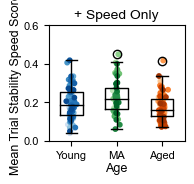

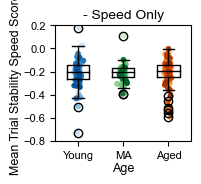

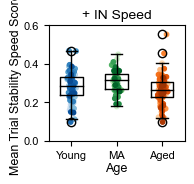

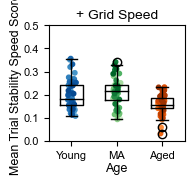

In [41]:
''' Plot Figure S6G '''

#Plot Figure S6G (first)
fig, ax = plt.subplots(figsize = (1.75,1.5))
strialstabscore = [strialstabscore99[y_sind99], strialstabscore99[ma_sind99], strialstabscore99[age_sind99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(strialstabscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(strialstabscore)):
    y = strialstabscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session99[i], edgecolors = col_session99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.6])
ax.set_yticks([0,0.2,0.4,0.6])
plt.savefig(save_folder + 'S6Gfirst.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Gfirst.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6G (second)
fig, ax = plt.subplots(figsize = (1.75,1.5))
strialstabscore = [strialstabscore1[y_sind1], strialstabscore1[ma_sind1], strialstabscore1[age_sind1]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(strialstabscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(strialstabscore)):
    y = strialstabscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_session1[i], edgecolors = col_session1[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('- Speed Only', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([-0.8,0.2])
ax.set_yticks([-0.8,-0.6,-0.4,-0.2,0.0,0.2])
plt.savefig(save_folder + 'S6Gsecond.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Gsecond.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6G (third)
fig, ax = plt.subplots(figsize = (1.75,1.5))
strialstabscore = [strialstabscoreint99[y_sindint], strialstabscoreint99[ma_sindint], strialstabscoreint99[age_sindint]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(strialstabscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(strialstabscore)):
    y = strialstabscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessionint[i], edgecolors = col_sessionint[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ IN Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.6])
ax.set_yticks([0,0.2,0.4,0.6])
plt.savefig(save_folder + 'S6Gthird.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Gthird.svg', dpi=400, bbox_inches='tight')
plt.show()

#Plot Figure S6G (fourth)
fig, ax = plt.subplots(figsize = (1.75,1.5))
strialstabscore = [strialstabscoregrid99[y_sindgrid99], strialstabscoregrid99[ma_sindgrid99], strialstabscoregrid99[age_sindgrid99]]
labels = ['Young','MA','Aged']
w = 0.5
plt.boxplot(strialstabscore, widths = w, labels = labels, medianprops = dict(color = 'black'))

for i in range(len(strialstabscore)):
    y = strialstabscore[i]
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, color = col_sessiongrid99[i], edgecolors = col_sessiongrid99[i], s = 10)
            
#ax.legend(ncol = 3, handles = handles, labels = label_mice, loc = 'upper right',bbox_to_anchor=(1.8, 1))
ax.set_title('+ Grid Speed', fontsize=10, pad=5)
ax.set_xlabel('Age', fontsize=9, labelpad=1)
ax.set_ylabel('Mean Trial Stability Speed Score', fontsize = 9, labelpad=1)
ax.tick_params(labelsize = 8)
ax.set_ylim([0,0.5])
ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.savefig(save_folder + 'S6Gfourth.png', dpi=400, bbox_inches='tight')
plt.savefig(save_folder + 'S6Gfourth.svg', dpi=400, bbox_inches='tight')
plt.show()

In [42]:
'''Speed Cell Trial Stability Score Statistics with Multiple Comparisons by Session'''

print('n young, MA, aged sessions with + speed only cells: ')
print(len(y_sind99),len(ma_sind99),len(age_sind99))

print('\n+ Speed Only Cell Slope Results:')
print('scoreyoung ± SEM; score_MA ± SEM; score_old ± SEM')
print(str(np.round(np.mean(strialstabscore99[y_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[y_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[ma_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[ma_sind99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore99[age_sind99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore99[age_sind99]), 4)))
stat, p_diff = stats.kruskal(strialstabscore99[y_sind99],strialstabscore99[ma_sind99],strialstabscore99[age_sind99])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind99,ma_sind99,age_sind99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])
Scorepos = list(strialstabscore99[allidx])
Scoreintpos = list(strialstabscoreint99[allidx])
Scoregridpos = list(strialstabscoregrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg, Scorepos, Scoreintpos, Scoregridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','trialstabscoreneg','trialstabscorepos','trialstabscoreintpos','trialstabscoregridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'trialstabscorepos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + speed only cells: 
88 56 94

+ Speed Only Cell Slope Results:
scoreyoung ± SEM; score_MA ± SEM; score_old ± SEM
0.1945 ± 0.0085 ; 0.2269 ± 0.0116 ; 0.1739 ± 0.0067
KW stat = 14.322619459962425
p_session = 0.0007760374877581466


,1.0,2.0,3.0
1.0,1.000000,0.053527,0.065762
2.0,0.053527,1.000000,0.000405
3.0,0.065762,0.000405,1.000000


In [43]:
print('n young, MA, aged sessions with - speed only cells: ')
print(len(y_sind1),len(ma_sind1),len(age_sind1))

print('\n- Speed Only Cell Score Results:')
print('score_young ± SEM; score_MA ± SEM; score_old ± SEM')
print(str(np.round(np.mean(strialstabscore1[y_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[y_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[ma_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[ma_sind1]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscore1[age_sind1]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscore1[age_sind1]), 4)))
()
stat, p_diff = stats.kruskal(strialstabscore1[y_sind1],strialstabscore1[ma_sind1],strialstabscore1[age_sind1])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sind1,ma_sind1,age_sind1))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])
Scorepos = list(strialstabscore99[allidx])
Scoreintpos = list(strialstabscoreint99[allidx])
Scoregridpos = list(strialstabscoregrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg,Scorepos,Scoreintpos,Scoregridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','trialstabscoreneg','trialstabscorepos','trialstabscoreintpos','trialstabscoregridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'trialstabscoreneg', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with - speed only cells: 
89 51 92

- Speed Only Cell Score Results:
score_young ± SEM; score_MA ± SEM; score_old ± SEM
-0.2127 ± 0.0121 ; -0.2104 ± 0.0115 ; -0.2081 ± 0.0116
KW stat = 1.0949447759448958
p_session = 0.5784099602292718


,1.0,2.0,3.0
1.0,1.000000,0.991875,0.991875
2.0,0.991875,1.000000,0.949591
3.0,0.991875,0.949591,1.000000


In [44]:
print('n young, MA, aged sessions with + IN speed cells: ')
print(len(y_sindint),len(ma_sindint),len(age_sindint))

print('\n+ IN Speed Cell Score Results:')
print('score_young ± SEM; score_MA ± SEM; score_old ± SEM')
print(str(np.round(np.mean(strialstabscoreint99[y_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoreint99[y_sindint]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscoreint99[ma_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoreint99[ma_sindint]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscoreint99[age_sindint]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoreint99[age_sindint]), 4)))
()
stat, p_diff = stats.kruskal(strialstabscoreint99[y_sindint],strialstabscoreint99[ma_sindint],strialstabscoreint99[age_sindint])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindint,ma_sindint,age_sindint))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])
Scorepos = list(strialstabscore99[allidx])
Scoreintpos = list(strialstabscoreint99[allidx])
Scoregridpos = list(strialstabscoregrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg,Scorepos,Scoreintpos,Scoregridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','trialstabscoreneg','trialstabscorepos','trialstabscoreintpos','trialstabscoregridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'trialstabscoreintpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + IN speed cells: 
94 58 95

+ IN Speed Cell Score Results:
score_young ± SEM; score_MA ± SEM; score_old ± SEM
0.2813 ± 0.0072 ; 0.3105 ± 0.0076 ; 0.2623 ± 0.0075
KW stat = 19.479754104082758
p_session = 5.8887774528083895e-05


,1.0,2.0,3.0
1.0,1.000000,0.015566,0.031581
2.0,0.015566,1.000000,0.000023
3.0,0.031581,0.000023,1.000000


In [45]:
print('n young, MA, aged sessions with + grid speed cells: ')
print(len(y_sindgrid99),len(ma_sindgrid99),len(age_sindgrid99))

print('\n+ Grid Speed Cell Score Results:')
print('score_young ± SEM; score_MA ± SEM; score_old ± SEM')
print(str(np.round(np.mean(strialstabscoregrid99[y_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoregrid99[y_sindgrid99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscoregrid99[ma_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoregrid99[ma_sindgrid99]), 4)) + ' ; ' 
      + str(np.round(np.mean(strialstabscoregrid99[age_sindgrid99]), 4)) + ' ± ' + str(np.round(stats.sem(strialstabscoregrid99[age_sindgrid99]), 4)))
()
stat, p_diff = stats.kruskal(strialstabscoregrid99[y_sindgrid99],strialstabscoregrid99[ma_sindgrid99],strialstabscoregrid99[age_sindgrid99])
print('KW stat = ' + str(stat))
print('p_session = ' + str(p_diff))

# Collect all relevant data into pandas dataframe
allidx = np.concatenate((y_sindgrid99,ma_sindgrid99,age_sindgrid99))
Animal_ID = list(seshmice[allidx])
Session = list(seshcount[allidx])
Age_Group = list(seshage[allidx])
Scoreneg = list(strialstabscore1[allidx])
Scorepos = list(strialstabscore99[allidx])
Scoreintpos = list(strialstabscoreint99[allidx])
Scoregridpos = list(strialstabscoregrid99[allidx])

tuples = list(zip(Animal_ID, Session, Age_Group, Scoreneg,Scorepos,Scoreintpos,Scoregridpos))
tuples

df = pd.DataFrame(tuples, columns = ['AnimalID', 'Session', 'AgeGroup','trialstabscoreneg','trialstabscorepos','trialstabscoreintpos','trialstabscoregridpos'])

#run post hoc tests
ph.posthoc_conover(df, val_col = 'trialstabscoregridpos', group_col = 'AgeGroup', p_adjust = 'holm')

n young, MA, aged sessions with + grid speed cells: 
52 57 50

+ Grid Speed Cell Score Results:
score_young ± SEM; score_MA ± SEM; score_old ± SEM
0.1991 ± 0.0087 ; 0.2086 ± 0.0075 ; 0.1581 ± 0.0059
KW stat = 22.092822785374153
p_session = 1.5944264391446835e-05


,1.0,2.0,3.0
1.0,1.000000,0.159061,0.001436
2.0,0.159061,1.000000,0.000006
3.0,0.001436,0.000006,1.000000
